In [2]:
import random
import numpy as np
import gymnasium as gym
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

Code based on and partly taken from https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
# importing the tensorflow package
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
class DQNAgent:
    def __init__(self, epsilon = 1.0):
        """"
        # This constructor initializes the class with an exploration rate (epsilon), sets up the actions possible
        # in the action space, creates a memory buffer, sets a discount rate (gamma), sets up an epsilon decay
        # rate for adjusting exploration, sets a learning rate, and builds the deep learning model.

        # Define the action space for the car race environment, with varying combinations of steering, acceleration, and brake

        # action space Structure
        #       (Steering Wheel, speed, Break)
        # Range       -1-1       0-1   0-1

        """
        self.action_space    = [(-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2),
                                (-1, 1,   0), (0, 1,   0), (1, 1,   0),
                                (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2),
                                (-1, 0,   0), (0, 0,   0), (1, 0,   0)]
        
        self.memory          = deque(maxlen=5000) # Set up memory with a maximum size of 5000 for the agent's experiences
        self.gamma           = 0.95 # Discount rate
        self.epsilon         = epsilon # Exploration rate
        self.epsilon_min     = 0.1
        self.epsilon_decay   = 0.9999
        self.learning_rate   = 0.001

        # Create two instances of the model, one for predicting the Q-values, and another as the target model
        # The target model is used to stabilize learning, by providing a fixed set of weights for calculating target values as seen in the Deep Q-Network paper
        self.model           = self.build_model()
        self.target_model    = self.build_model()
        self.update_target_model()  # Copy weights from the model to the target model

    def build_model(self):
        # Define the deep learning model architecture - a CNN in this case (for visual tasks like the Box2D or Atari games)
        # Model structure: Two convolutional layers, followed by flattening and dense layers
        model = Sequential()
        model.add(Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(96, 96, 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=12, kernel_size=(4, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(216, activation='relu'))
        model.add(Dense(len(self.action_space), activation=None))
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate, epsilon=1e-7))
        return model

    def update_target_model(self):
        # Function to copy the weights from the model to the target model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        # Function to store an experience in memory for experience replay
        self.memory.append((state, self.action_space.index(action), reward, next_state, done))

    def action(self, state):
        # Function to select an action, either randomly (exploration) or the one with maximum predicted Q-value (exploitation)
        if np.random.rand() > self.epsilon:
            # Get action with max value
            action_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
            action_index = np.argmax(action_values[0])
        else:
            # Get random action
            action_index = random.randrange(len(self.action_space))
        return self.action_space[action_index]

    def learn(self, batch_size):
        # Function to update the model by replaying experiences from the memory
        minibatch = random.sample(self.memory, batch_size)
        train_state = []
        train_target = []
        
        # Get all predicted actions on all states
        for state, action_index, reward, next_state, done in minibatch:
            # For each experience, calculate the target Q-value
            target = self.model.predict(np.expand_dims(state, axis=0), verbose=0)[0]
            if done:
                target[action_index] = reward
            else:
                t = self.target_model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0]
                target[action_index] = reward + self.gamma * np.amax(t)
            # Save the input and output values
            train_state.append(state)
            train_target.append(target)
        # Update the model using the states and target Q-values
        self.model.fit(np.array(train_state), np.array(train_target), epochs=1, verbose=0)
        
        # Decay the epsilon value after each learning step
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        # Function to load weights into the model from a file, then copy them to the target model (for playing with trained weights)
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        # Function to save the weights of the target model to a file (for later usage of the load function)
        self.target_model.save_weights(name)

In [6]:
def process_state_image(state):
    """
    This function processes the input state (an image) by converting it to grayscale and normalizing the pixel values.
    The purpose of this preprocessing step is to simplify the input without losing too much information.
    
    :param state: A 3-channel color image representing a game state.
    :return: A grayscale image with normalized pixel values.
    """
    
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)    # Convert color image to grayscale
    state = state.astype(float)                        # Convert data to float
    state /= 255.0                                     # Normalize
    return state

def generate_state_frame_stack_from_queue(deque):
    """
    A Function that takes a deque containing multiple frames of the game state and 
    converts it into a numpy array, then transposes the array to move the 'stack' dimension to the channel dimension. 
    This way, the stack of frames can be processed by a Convolutional Neural Network as separate channels.
    
    :param deque: A deque object containing multiple frames of the game state.
    :return: A numpy array where the stack dimension has been moved to the channel dimension.
    """
    frame_stack = np.array(deque)    
    return np.transpose(frame_stack, (1, 2, 0))


In [8]:
# Paramters for training like the amount of episodes and frequency of timesteps to update the target network
ENDING_EPISODE                = 100 
SKIP_FRAMES                   = 2 
TRAINING_BATCH_SIZE           = 64
UPDATE_TARGET_MODEL_FREQUENCY = 5


def train():
    # Create the gym environment and the agent for the CarRacing-v2 env.
    env = gym.make('CarRacing-v2')
    agent = DQNAgent()

    # Train the agent through multiple episodes (up until the defined episode)
    for episode in range(1, ENDING_EPISODE+1):

        # Initialize values for each episode
        init_state = env.reset()
        init_state = process_state_image(init_state[0]) # Image processing for the network with the defined function

        # Set variables for training
        total_reward = 0
        negative_reward_counter = 0
        state_frame_stack_queue = deque([init_state] * 3, maxlen=3)
        time_frame_counter = 1
        done = False
        
        while True: # Continue until the episode ends
            current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
            action = agent.action(current_state_frame_stack)
            reward = 0

            # Step the environment and get the reward
            for each_frame in range(SKIP_FRAMES+1):
                next_state, frame_reward, done, info, _ = env.step(action)
                reward += frame_reward
                if done:
                    break

            # Terminate this episode if continuously getting negative rewards
            if time_frame_counter > 100 and reward < 0:
                negative_reward_counter = negative_reward_counter + 1
            else:
                negative_reward_counter = 0

            # Optionally you can define bonusses for actions, in this case a bonus is given for using full gas
            if action[1] == 1 and action[2] == 0:
                reward *= 1.5

            # Sum up reward
            total_reward += reward

            # Save the next state
            next_state = process_state_image(next_state)
            state_frame_stack_queue.append(next_state)
            next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

            # Memorize the agent's current state, action, reward and next state as one experience for experience replay
            agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)
            
            # Multiple conditions for stopping the episode, like a negative reward
            if done or negative_reward_counter >= 25 or total_reward < 0:
                print('Episode: {}/{}, Time Frames: {}, Total Rewards(adjusted): {:.2}'.format(episode, ENDING_EPISODE, time_frame_counter, float(total_reward)))
                break

            # Allow the model to learn from experience replay
            if len(agent.memory) > TRAINING_BATCH_SIZE:
                agent.learn(TRAINING_BATCH_SIZE)

            time_frame_counter += 1

        # Update the target model after the defined number of episodes
        if episode % UPDATE_TARGET_MODEL_FREQUENCY == 0:
            agent.update_target_model()
            print(episode, "Updated network")

        # Save the model after the last episode for future usage
        if episode == ENDING_EPISODE:
            agent.save('./model/trial_{}.h5'.format(episode))

    env.close()

train()

Episode: 1/100, Time Frames: 125, Total Rewards(adjusted): 9.1
Episode: 2/100, Time Frames: 136, Total Rewards(adjusted): 2.9e+01
Episode: 3/100, Time Frames: 195, Total Rewards(adjusted): 4.4e+01
Episode: 4/100, Time Frames: 190, Total Rewards(adjusted): 5.4e+01
Episode: 5/100, Time Frames: 58, Total Rewards(adjusted): -0.15
5 Updated network
Episode: 6/100, Time Frames: 125, Total Rewards(adjusted): 2.9e+01
Episode: 7/100, Time Frames: 125, Total Rewards(adjusted): 2.8e+01
Episode: 8/100, Time Frames: 125, Total Rewards(adjusted): 4.6e+01
Episode: 9/100, Time Frames: 125, Total Rewards(adjusted): 1.9
Episode: 10/100, Time Frames: 80, Total Rewards(adjusted): -0.18
10 Updated network
Episode: 11/100, Time Frames: 214, Total Rewards(adjusted): 5e+01
Episode: 12/100, Time Frames: 94, Total Rewards(adjusted): -0.28
Episode: 13/100, Time Frames: 125, Total Rewards(adjusted): 3.1e+01
Episode: 14/100, Time Frames: 125, Total Rewards(adjusted): 1.5e+01
Episode: 15/100, Time Frames: 141, Tota

The code below opens the environment and shows how the trained model is playing the game. As it is possible for the model to have performance issues when exectued in a jupyter notebook, the same code is compressed into the run_model.py

In [7]:
# Specify the saved model to load
MODEL = 'model/trial_100.h5'

def run_game():
    env = gym.make('CarRacing-v2', render_mode="human") # Create the gym environment and the agent for the CarRacing-v2 env.
    agent = DQNAgent(epsilon=0) # Epsilon 0 allows deterministic action selection
    agent.load(MODEL) # load the pre-trained model

    # Initialize the state of the environment and process the initial image
    init_state = env.reset()
    init_state = process_state_image(init_state[0])

    total_reward = 0
    state_frame_stack_queue = deque([init_state] * 3, maxlen=3)
    time_frame_counter = 1
    
    # Game loop, this renders it and executes the actions given
    while True:
        # Render the environment on screen
        env.render()

        current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.action(current_state_frame_stack)
        next_state, reward, done, info, _ = env.step(action) # Take a step in the environment using the selected action
        
        # Print the selected action
        print(f"Selected action at step {time_frame_counter}: {action}")

        total_reward += reward

        # Process the image of the next state and add it to the deque
        next_state = process_state_image(next_state)
        state_frame_stack_queue.append(next_state)
   
        # If the game is done, print the total frames and reward, then break the loop (as seen in the training)
        if done:
            print('Time Frames: {}, Total Rewards: {:.2}'.format(time_frame_counter, float(total_reward)))
            break
        time_frame_counter += 1

    env.close()

run_game()

Selected action at step 1: (0, 0, 0.2)
Selected action at step 2: (-1, 1, 0)
Selected action at step 3: (-1, 1, 0)
Selected action at step 4: (-1, 0, 0)
Selected action at step 5: (1, 1, 0.2)
Selected action at step 6: (-1, 1, 0)
Selected action at step 7: (1, 0, 0.2)
Selected action at step 8: (1, 1, 0.2)
Selected action at step 9: (1, 0, 0)
Selected action at step 10: (1, 0, 0)
Selected action at step 11: (1, 0, 0)
Selected action at step 12: (1, 0, 0)
Selected action at step 13: (-1, 1, 0)
Selected action at step 14: (-1, 1, 0)
Selected action at step 15: (-1, 1, 0)
Selected action at step 16: (-1, 1, 0)
Selected action at step 17: (-1, 1, 0)
Selected action at step 18: (-1, 1, 0)
Selected action at step 19: (0, 0, 0.2)
Selected action at step 20: (0, 1, 0.2)
Selected action at step 21: (-1, 1, 0)
Selected action at step 22: (1, 1, 0)
Selected action at step 23: (0, 1, 0)
Selected action at step 24: (1, 1, 0)
Selected action at step 25: (0, 1, 0)
Selected action at step 26: (1, 1, 0

KeyboardInterrupt: 

### Evaluation

The findings from training the RL agent in the CarRacing environment across different numbers
of episodes reveal a progressive improvement in performance and driving style. The agent was
trained for 5, 10, 100 and 500 episodes.

After 5 episodes, the agent exhibits rudimentary control over the car. Its strategy at this stage
primarily involves braking and slowly moving forward, gradually accumulating rewards but offering
little in the way of strategic navigation.

Increasing the training duration to 10 episodes, the agent begins to show the first signs of a more
purposeful driving direction. While the driving pattern at this stage is still far from optimal, as it
quickly leads to mistakes being made and thus failing to run continuously, there’s an improvement
over the initial strategy.

The model with 100 episodes already shows great results. It seems as a minimum number of
episodes is required in order for the agent to gather the basic techniques of driving. However the
model does not seem as stable, when going around corners the actions taken often lead to minor
setbacks and the car getting of the track. When the car is of the track, it has a hard time going
into the correct direction and can get stuck quickly.

The leap to 500 episodes is another leap the agent’s performance. It displays a proper driving
style, smoothly navigating the track while minimizing off-road detours. The improvement can be
seen mainly in the stable driving style, while the reward only improves slightly. However, there
remain a few areas for improvement. In certain iterations and specific track layouts, the agent
exhibits a tendency to cut corners. This results in the car sometimes ending up facing the wrong
direction. Nonetheless, the overall performance at this stage is superior to earlier stages, as it
often finds its way back to the road and is able to recover minor mishaps.

The maximum total reward of each model after trying out five runs each was manually observed
and is visualized below.

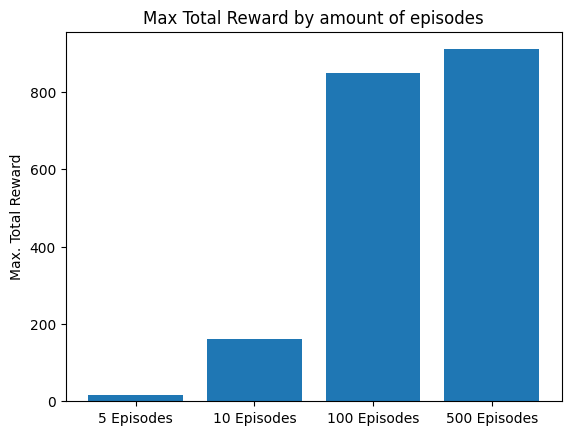

In [3]:
# Manually observed highest total reward 
height = [17, 61, 849, 910]
bars = ('5 Episodes', '10 Episodes', '100 Episodes', '500 Episodes')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.ylabel('Max. Total Reward')
plt.title('Max Total Reward by amount of episodes')
# Show graphic
plt.show()

### Learnings and challenges

Over the span of the one of the key areas where significant learning took place was during the implementation of the \ac{dqn}. It helped understanding the theoretical framework behind reinforcement learning and deep learning.
 
Alongside this rewarding learning experience, there were some challenges encountered, especially with software dependencies. I faced issues with installing SWIG for the Box2D environments, which was resolved by installing SWIG manually. Also, finding the correct version of Tensorflow that can make use of my GPU. This necessitated research and deep dive into the dependencies of these libraries, their compatibility with other tools. In the process, it seemed that my CUDA version was not supported, forcing a downgrade from CUDA 12.2 to 11.2. These challenges broadened my understanding of python and virtual environments in python and were part of the learning experience.

In summary, this project was a perfect blend of theory and practice, with significant learnings and challenges that have greatly enriched my understanding of deep learning, reinforcement learning, and dependency management.